In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fenics as fe

import sys
sys.path.insert(0, "../src")

from swe import ShallowOne

In [2]:
control = dict(nx=500, dt=2., theta=0.6, simulation="tidal_flow")

swe = ShallowOne(control=control, 
                 params=dict(nu=1.,
                             shore_start=1000, shore_height=2.5,
                             bump_height=0., bump_centre=1000., bump_width=400))
swe_perturbed = ShallowOne(control=control, 
                           params=dict(nu=1., 
                                       shore_start=4000, shore_height=2.5,
                                       bump_height=0., bump_centre=8000., bump_width=400)) 
t = 0.

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


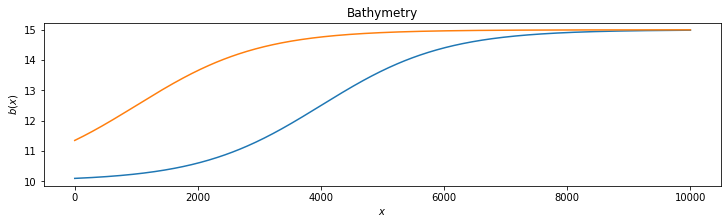

In [3]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 3))
fe.plot(40 - swe_perturbed.H)
fe.plot(40 - swe.H)
ax.set_title("Bathymetry")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$b(x)$")
plt.show()

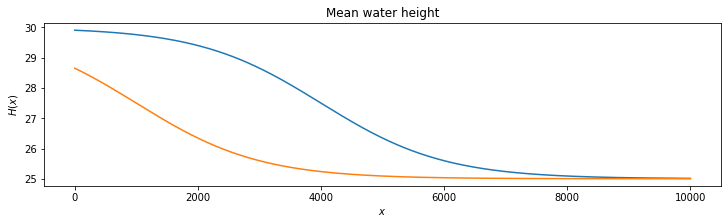

In [4]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 3))
fe.plot(swe_perturbed.H)
fe.plot(swe.H)
ax.set_title("Mean water height")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$H(x)$")
plt.show()

In [5]:
fe.set_log_level(50)

t_final = t + 60 * 60 * 12.
nt = int((t_final - t) / swe.dt)

i_save = 0
nt_skip = 60
nt_save = len([i for i in range(nt) if i % nt_skip == 0])

t_out = np.zeros((nt_save, ))
u_out = np.zeros((nt_save, len(swe.mesh.coordinates())))
up_out = np.zeros((nt_save, len(swe.mesh.coordinates())))

h_out = np.zeros((nt_save, len(swe.mesh.coordinates())))
hp_out = np.zeros((nt_save, len(swe.mesh.coordinates())))

print(t)
from tqdm import tqdm
for i in tqdm(range(nt)):
    t += swe.dt
    swe.solve(t)
    swe_perturbed.solve(t)
    
    if i % nt_skip == 0:
        t_out[i_save] = t
        u, h = swe.du.split()
        up, hp = swe_perturbed.du.split()
        u_out[i_save, :] = u.compute_vertex_values()
        up_out[i_save, :] = up.compute_vertex_values()
        
        h_out[i_save, :] = h.compute_vertex_values()
        hp_out[i_save, :] = hp.compute_vertex_values()
        
        i_save += 1

0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21600/21600 [03:57<00:00, 90.97it/s]


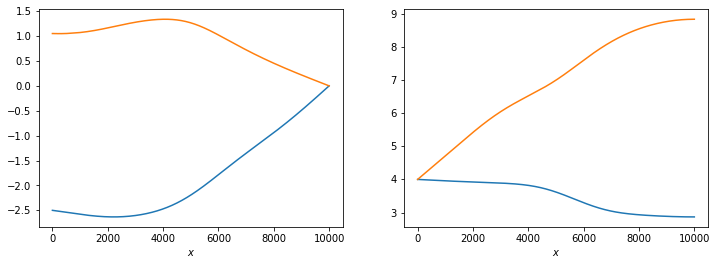

In [6]:
x_out = swe.mesh.coordinates().copy()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(x_out, u_out[i_save - 1, :])
axs[0].plot(x_out, up_out[i_save - 1, :])

axs[1].plot(x_out, h_out[i_save - 1, :])
axs[1].plot(x_out, hp_out[i_save - 1, :])

for ax in axs: ax.set_xlabel(r"$x$")
plt.show()

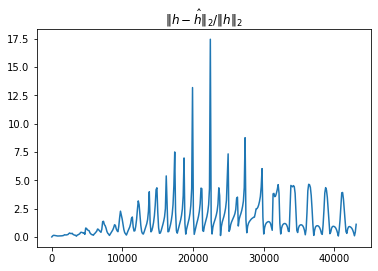

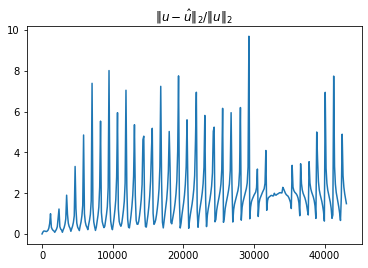

In [7]:
norm = np.linalg.norm
plt.plot(t_out, 
         norm(h_out - hp_out, axis=1) / norm(h_out, axis=1))
plt.title(r"$\Vert h - \hat{h} \Vert_2 / \Vert h \Vert_2$")
plt.show()

plt.plot(t_out, 
         norm(u_out - up_out, axis=1) / norm(u_out, axis=1))
plt.title(r"$\Vert u - \hat{u} \Vert_2 / \Vert u \Vert_2$")
plt.show()